# Entrenamiento del modelo con los tweets pre-clasificados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch


# Cargar el dataset
df = pd.read_csv("tweets_better_classified.csv")

# Preprocesar las etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])  # Ajusta 'categoria' a la columna correspondiente

# Dividir el dataset en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Inicializar el tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Función para tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples['Texto'], padding="max_length", truncation=True, max_length=128)

# Aplicar el tokenizer a los datos de entrenamiento y prueba
train_encodings = tokenizer(list(train['Texto'].values), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test['Texto'].values), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas en tensores
train_labels = torch.tensor(train['label'].values)
test_labels = torch.tensor(test['label'].values)

# Crear un dataset personalizado
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Cargar el modelo BERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)  

# Definir los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio para guardar los resultados
    num_train_epochs=10,              # Número de épocas
    per_device_train_batch_size=16,  # Tamaño del lote en entrenamiento
    per_device_eval_batch_size=64,   # Tamaño del lote en evaluación
    warmup_steps=500,                # Número de pasos para warmup
    weight_decay=0.01,               # Tasa de decaimiento del peso
    logging_dir='./logs',            # Directorio para guardar los logs
    logging_steps=10,
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Reporte de clasificación
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))


In [ ]:
model.save_pretrained('./my_model')
tokenizer.save_pretrained('./my_model')

# Clasificando tweets con BERT pre-entrenado

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch


In [11]:

# Cargar el tokenizador y el modelo
tokenizer = BertTokenizer.from_pretrained('./my_model')
model = BertForSequenceClassification.from_pretrained('./my_model')

# Cargar el LabelEncoder (Asegúrate de que es el mismo usado durante el entrenamiento)
df_original = pd.read_csv("tweets_better_classified.csv")  # Dataset original para recuperar las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(df_original['Tipo'])  # Ajusta 'Tipo' a la columna de etiquetas original

# Cargar el dataset filtrado
df_filtered = pd.read_csv("tweets_globales_filtrados.csv")

# Define una función para predecir nuevos textos
def predict_new_text(text):
    # Tokenizar el texto
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Asegúrate de mover el modelo y los inputs a la GPU si está disponible
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Hacer la predicción
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Obtener la clase predicha
    predicted_class = torch.argmax(logits, dim=1).item()

    # Decodificar la etiqueta predicha
    predicted_label = label_encoder.inverse_transform([predicted_class])

    return predicted_label[0]

# Predecir etiquetas para la columna 'texto' y almacenarlas en una nueva columna 'Tipo'
df_filtered['Tipo'] = df_filtered['Texto'].apply(predict_new_text)

# Guardar el nuevo DataFrame en un archivo CSV
df_filtered.to_csv("tweets_globales_clasificados.csv", index=False)

print("Archivo 'tweets_classified.csv' guardado con las etiquetas predichas.")


Archivo 'tweets_classified.csv' guardado con las etiquetas predichas.


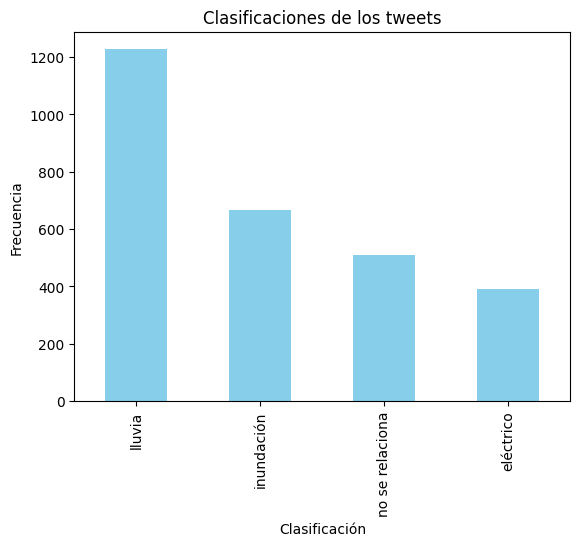

In [13]:
import matplotlib.pyplot as plt
tweets_clean_classified = "tweets_globales_clasificados.csv"
df_tweets_clean_fil = pd.read_csv(tweets_clean_classified)

tipo_counts = df_tweets_clean_fil['Tipo'].value_counts()

# Creación del histograma
tipo_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Clasificación')
plt.ylabel('Frecuencia')
plt.title('Clasificaciones de los tweets')
plt.show()

# Tweets multiclasificados

In [21]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax

# Cargar el modelo y el tokenizer pre-entrenado
model = BertForSequenceClassification.from_pretrained('./my_model4')
tokenizer = BertTokenizer.from_pretrained('./my_model4')

# Definir un texto de ejemplo
texto_ejemplo = "Fuertes inundaciones accidente a en la avenida garza sada  en Monterrey"

# Tokenizar el texto
inputs = tokenizer(texto_ejemplo, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Asegurarse de que el modelo está en modo de evaluación
model.eval()

# Hacer la predicción (no se necesita calcular los gradientes)
with torch.no_grad():
    outputs = model(**inputs)

# Obtener las logits y calcular las probabilidades con softmax
logits = outputs.logits
probabilidades = softmax(logits.numpy(), axis=1)[0]

# Cargar el LabelEncoder para obtener las categorías
df = pd.read_csv("df_tweets_procesados.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])

# Obtener los nombres de las categorías
categorias = label_encoder.classes_

# Crear un nuevo DataFrame con las categorías y las probabilidades
df_resultado = pd.DataFrame([probabilidades], columns=categorias)

# Agregar el texto de ejemplo para referencia
df_resultado['Texto'] = texto_ejemplo

# Mostrar el DataFrame con las categorías y sus porcentajes de presencia
print(df_resultado)

   eléctrico  incendio  inundación    lluvia  no se relaciona  problema vial  \
0   0.020568  0.022571    0.033255  0.009869          0.01463       0.899107   

                                               Texto  
0  Fuertes inundaciones accidente a en la avenida...  


# Segunda arquitectura

# este es el nuevo clasificador!!!

In [45]:
import torch 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import classification_report
import evaluate

# Cargar el dataset
df = pd.read_csv("df_balanceado.csv")

# Preprocesar etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])  

# Dividir el dataset en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Inicializar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizar los textos (Asegúrate de que son strings)
train_encodings = tokenizer(train['Texto'].astype(str).tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test['Texto'].astype(str).tolist(), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas a tensores
train_labels = torch.tensor(train['label'].values)
test_labels = torch.tensor(test['label'].values)

# Crear dataset personalizado para el entrenamiento
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]) 
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Cargar el modelo preentrenado de BERT para clasificación de secuencias
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Cargar la métrica de accuracy desde la nueva biblioteca evaluate
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.03,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  
    greater_is_better=True,
    learning_rate=2e-5
)

# Crear el Trainer para el modelo
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics 
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] 
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)
pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)
preds = torch.argmax(pred_probs, dim=1).numpy()

# Imprimir reporte de clasificación
print(classification_report(test_labels.numpy(), preds, target_names=label_encoder.classes_))

# Guardar el modelo y el tokenizer
model.save_pretrained('./my_model6')
tokenizer.save_pretrained('./my_model6')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\a00832699\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/426 [00:00<?, ?it/s]C:\Users\a00832699\AppData\Local\Temp\ipykernel_14216\941573390.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
                                                
 12%|█▏        | 50/426 [01:26<10:53,  1.74s/it] 

{'loss': 1.671, 'grad_norm': 5.880342483520508, 'learning_rate': 1e-05, 'epoch': 0.35}


                                                 
 23%|██▎       | 100/426 [02:55<09:46,  1.80s/it]  

{'loss': 1.3983, 'grad_norm': 5.004861831665039, 'learning_rate': 2e-05, 'epoch': 0.7}






















                                                 
                                                
 23%|██▎       | 100/426 [03:14<09:46,  1.80s/it]
C:\Users\a00832699\AppData\Local\Temp\ipykernel_14216\941573390.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 1.1365094184875488, 'eval_accuracy': 0.6707964601769911, 'eval_runtime': 18.3804, 'eval_samples_per_second': 30.739, 'eval_steps_per_second': 0.979, 'epoch': 0.7}


                                                 
 35%|███▌      | 150/426 [04:42<08:29,  1.85s/it]  

{'loss': 0.9411, 'grad_norm': 4.041423797607422, 'learning_rate': 1.6932515337423315e-05, 'epoch': 1.06}


                                                 
 47%|████▋     | 200/426 [06:47<15:23,  4.09s/it]  

{'loss': 0.7253, 'grad_norm': 3.585031747817993, 'learning_rate': 1.3865030674846627e-05, 'epoch': 1.41}






















                                                 
                                                
 47%|████▋     | 200/426 [07:29<15:23,  4.09s/it]
C:\Users\a00832699\AppData\Local\Temp\ipykernel_14216\941573390.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.5354270935058594, 'eval_accuracy': 0.8407079646017699, 'eval_runtime': 42.0585, 'eval_samples_per_second': 13.434, 'eval_steps_per_second': 0.428, 'epoch': 1.41}


                                                   
 59%|█████▊    | 250/426 [09:43<05:01,  1.71s/it]  

{'loss': 0.5355, 'grad_norm': 6.749011993408203, 'learning_rate': 1.079754601226994e-05, 'epoch': 1.76}


                                                 
 70%|███████   | 300/426 [11:09<03:43,  1.77s/it]  

{'loss': 0.413, 'grad_norm': 4.840836524963379, 'learning_rate': 7.730061349693252e-06, 'epoch': 2.11}






















                                                 
                                                
 70%|███████   | 300/426 [11:28<03:43,  1.77s/it]
C:\Users\a00832699\AppData\Local\Temp\ipykernel_14216\941573390.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.3067410886287689, 'eval_accuracy': 0.9185840707964602, 'eval_runtime': 18.3101, 'eval_samples_per_second': 30.857, 'eval_steps_per_second': 0.983, 'epoch': 2.11}


                                                 
 82%|████████▏ | 350/426 [12:57<02:16,  1.79s/it]  

{'loss': 0.2877, 'grad_norm': 1.0295826196670532, 'learning_rate': 4.662576687116564e-06, 'epoch': 2.46}


                                                 
 94%|█████████▍| 400/426 [14:26<00:46,  1.79s/it]  

{'loss': 0.2689, 'grad_norm': 4.481869220733643, 'learning_rate': 1.5950920245398775e-06, 'epoch': 2.82}






















                                                 
                                                
 94%|█████████▍| 400/426 [14:45<00:46,  1.79s/it]
C:\Users\a00832699\AppData\Local\Temp\ipykernel_14216\941573390.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.24593138694763184, 'eval_accuracy': 0.9309734513274336, 'eval_runtime': 18.4244, 'eval_samples_per_second': 30.666, 'eval_steps_per_second': 0.977, 'epoch': 2.82}


                                                 
100%|██████████| 426/426 [15:31<00:00,  2.19s/it]  
C:\Users\a00832699\AppData\Local\Temp\ipykernel_14216\941573390.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'train_runtime': 931.6598, 'train_samples_per_second': 7.277, 'train_steps_per_second': 0.457, 'train_loss': 0.7483531645206218, 'epoch': 3.0}


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


                 precision    recall  f1-score   support

      eléctrico       0.87      0.85      0.86        62
       incendio       0.94      0.94      0.94        47
     inundación       0.93      1.00      0.97        57
         lluvia       1.00      0.98      0.99       247
no se relaciona       0.80      0.80      0.80        79
  problema vial       0.92      0.95      0.93        73

       accuracy                           0.93       565
      macro avg       0.91      0.92      0.91       565
   weighted avg       0.93      0.93      0.93       565



('./my_model6\\tokenizer_config.json',
 './my_model6\\special_tokens_map.json',
 './my_model6\\vocab.txt',
 './my_model6\\added_tokens.json')

In [13]:
import matplotlib.pyplot as plt

# Recuperar los registros de entrenamiento y evaluación
training_logs = trainer.state.log_history

# Filtrar los valores de accuracy y epochs de los logs
train_accuracy = [log['accuracy'] for log in training_logs if 'accuracy' in log]  # Precisión del conjunto de entrenamiento
eval_accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]  # Precisión del conjunto de evaluación
epochs = range(1, len(train_accuracy) + 1)

# Graficar accuracy de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'trainer' is not defined

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax

# Cargar el modelo y el tokenizer pre-entrenado
model = BertForSequenceClassification.from_pretrained('./my_model6')
tokenizer = BertTokenizer.from_pretrained('./my_model6')


In [12]:

# Definir un texto de ejemplo
texto_ejemplo = "Av Los Ángeles  a la altura de Churubusco en San Nicolás de los Garza súper inundado Cuidado Tomen sus precauciones"

# Tokenizar el texto
inputs = tokenizer(texto_ejemplo, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Asegurarse de que el modelo está en modo de evaluación
model.eval()

# Hacer la predicción (no se necesita calcular los gradientes)
with torch.no_grad():
    outputs = model(**inputs)

# Obtener las logits y calcular las probabilidades con softmax
logits = outputs.logits
probabilidades = softmax(logits.numpy(), axis=1)[0]

# Cargar el LabelEncoder para obtener las categorías
df = pd.read_csv("df_tweets_procesados.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])

# Obtener los nombres de las categorías
categorias = label_encoder.classes_

# Crear un nuevo DataFrame con las categorías y las probabilidades
df_resultado = pd.DataFrame([probabilidades], columns=categorias)

# Agregar el texto de ejemplo para referencia
df_resultado['Texto'] = texto_ejemplo

# Mostrar el DataFrame con las categorías y sus porcentajes de presencia
print(df_resultado)

   eléctrico  incendio  inundación    lluvia  no se relaciona  problema vial  \
0     0.0273   0.02136    0.522385  0.030191         0.306181       0.092583   

                                               Texto  
0  Av Los Ángeles  a la altura de Churubusco en S...  


# Tercera arquitectura

A esta arquitectura se le aplicó un submuestreo a la categoría de lluvia, debido a que esta categoría era muy dominante. A demás se le aplicó un early stopping para evitar el overfitting.

In [14]:
import torch 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import classification_report
import evaluate

# Cargar el dataset
df = pd.read_csv("df_balanceado.csv")

# Preprocesar etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])  

# Dividir el dataset en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Inicializar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizar los textos (Asegúrate de que son strings)
train_encodings = tokenizer(train['Texto'].astype(str).tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test['Texto'].astype(str).tolist(), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas a tensores
train_labels = torch.tensor(train['label'].values)
test_labels = torch.tensor(test['label'].values)

# Crear dataset personalizado para el entrenamiento
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]) 
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Cargar el modelo preentrenado de BERT para clasificación de secuencias
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Cargar la métrica de accuracy desde la nueva biblioteca evaluate
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.03,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  
    greater_is_better=True,
    learning_rate=2e-5
)

# Crear el Trainer para el modelo
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, 
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] 
    )

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)
pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)
preds = torch.argmax(pred_probs, dim=1).numpy()

# Imprimir reporte de clasificación
print(classification_report(test_labels.numpy(), preds, target_names=label_encoder.classes_))

# Guardar el modelo y el tokenizer
model.save_pretrained('./my_model7')
tokenizer.save_pretrained('./my_model7')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\a00832699\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/426 [00:00<?, ?it/s]C:\Users\a00832699\AppData\Local\Temp\ipykernel_21524\3922565134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 12%|█▏        | 50/426 [02:09<19:05,  3.05s/it]

{'loss': 1.7082, 'grad_norm': 7.558691024780273, 'learning_rate': 1e-05, 'epoch': 0.35}


 23%|██▎       | 100/426 [05:31<21:53,  4.03s/it]

{'loss': 1.4473, 'grad_norm': 6.184659957885742, 'learning_rate': 2e-05, 'epoch': 0.7}



 23%|██▎       | 100/426 [06:11<21:53,  4.03s/it]C:\Users\a00832699\AppData\Local\Temp\ipykernel_21524\3922565134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 1.2520684003829956, 'eval_accuracy': 0.5787610619469027, 'eval_runtime': 40.0387, 'eval_samples_per_second': 14.111, 'eval_steps_per_second': 0.45, 'epoch': 0.7}


 35%|███▌      | 150/426 [08:15<07:28,  1.62s/it]  

{'loss': 1.04, 'grad_norm': 5.366993427276611, 'learning_rate': 1.6932515337423315e-05, 'epoch': 1.06}


 47%|████▋     | 200/426 [09:38<06:24,  1.70s/it]

{'loss': 0.8191, 'grad_norm': 4.103612899780273, 'learning_rate': 1.3865030674846627e-05, 'epoch': 1.41}


                                                 
 47%|████▋     | 200/426 [09:55<06:24,  1.70s/it]C:\Users\a00832699\AppData\Local\Temp\ipykernel_21524\3922565134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.6713077425956726, 'eval_accuracy': 0.8247787610619469, 'eval_runtime': 17.1983, 'eval_samples_per_second': 32.852, 'eval_steps_per_second': 1.047, 'epoch': 1.41}


 59%|█████▊    | 250/426 [11:21<05:10,  1.76s/it]

{'loss': 0.5932, 'grad_norm': 10.44473934173584, 'learning_rate': 1.079754601226994e-05, 'epoch': 1.76}


 70%|███████   | 300/426 [12:46<03:33,  1.69s/it]

{'loss': 0.4749, 'grad_norm': 4.620251655578613, 'learning_rate': 7.730061349693252e-06, 'epoch': 2.11}


                                                 
 70%|███████   | 300/426 [13:04<03:33,  1.69s/it]C:\Users\a00832699\AppData\Local\Temp\ipykernel_21524\3922565134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.3767295777797699, 'eval_accuracy': 0.904424778761062, 'eval_runtime': 17.5993, 'eval_samples_per_second': 32.104, 'eval_steps_per_second': 1.023, 'epoch': 2.11}


 82%|████████▏ | 350/426 [16:10<04:46,  3.77s/it]

{'loss': 0.3534, 'grad_norm': 6.427361965179443, 'learning_rate': 4.662576687116564e-06, 'epoch': 2.46}


 94%|█████████▍| 400/426 [19:21<01:40,  3.88s/it]

{'loss': 0.3551, 'grad_norm': 7.150126934051514, 'learning_rate': 1.5950920245398775e-06, 'epoch': 2.82}


                                                 
 94%|█████████▍| 400/426 [19:59<01:40,  3.88s/it]C:\Users\a00832699\AppData\Local\Temp\ipykernel_21524\3922565134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.3152638375759125, 'eval_accuracy': 0.9185840707964602, 'eval_runtime': 38.3202, 'eval_samples_per_second': 14.744, 'eval_steps_per_second': 0.47, 'epoch': 2.82}


100%|██████████| 426/426 [20:58<00:00,  2.95s/it]
C:\Users\a00832699\AppData\Local\Temp\ipykernel_21524\3922565134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'train_runtime': 1258.7179, 'train_samples_per_second': 5.386, 'train_steps_per_second': 0.338, 'train_loss': 0.8172071036038824, 'epoch': 3.0}


100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


                 precision    recall  f1-score   support

      eléctrico       0.91      0.84      0.87        62
       incendio       0.96      0.94      0.95        47
     inundación       0.86      0.84      0.85        57
         lluvia       0.96      0.98      0.97       247
no se relaciona       0.81      0.84      0.82        79
  problema vial       0.95      0.97      0.96        73

       accuracy                           0.92       565
      macro avg       0.91      0.90      0.90       565
   weighted avg       0.92      0.92      0.92       565



('./my_model7\\tokenizer_config.json',
 './my_model7\\special_tokens_map.json',
 './my_model7\\vocab.txt',
 './my_model7\\added_tokens.json')

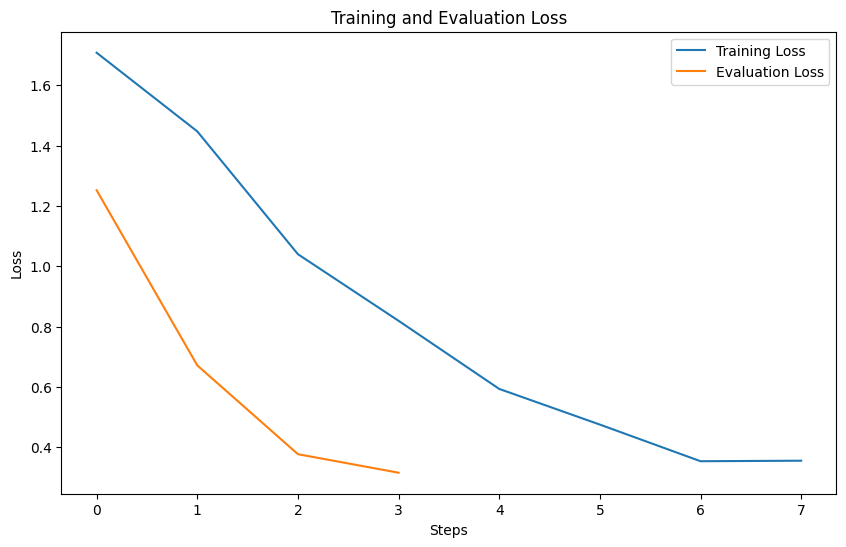

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Obtener los logs del entrenamiento
train_loss_history = trainer.state.log_history

# Filtrar los logs que contienen las pérdidas
train_losses = [entry['loss'] for entry in train_loss_history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in train_loss_history if 'eval_loss' in entry]

# Graficar las pérdidas
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()


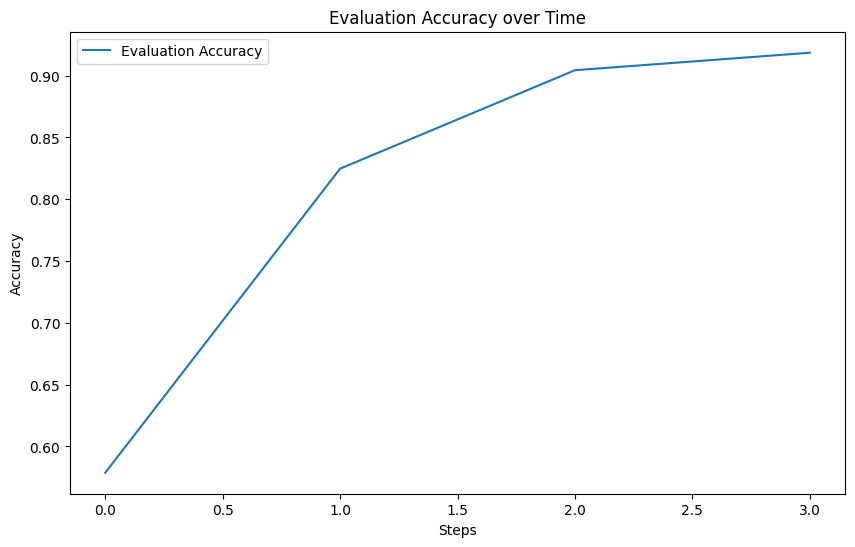

In [20]:
# Filtrar los logs que contienen la precisión
eval_accuracies = [entry['eval_accuracy'] for entry in train_loss_history if 'eval_accuracy' in entry]

# Graficar la precisión
plt.figure(figsize=(10,6))
plt.plot(eval_accuracies, label='Evaluation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy over Time')
plt.legend()
plt.show()


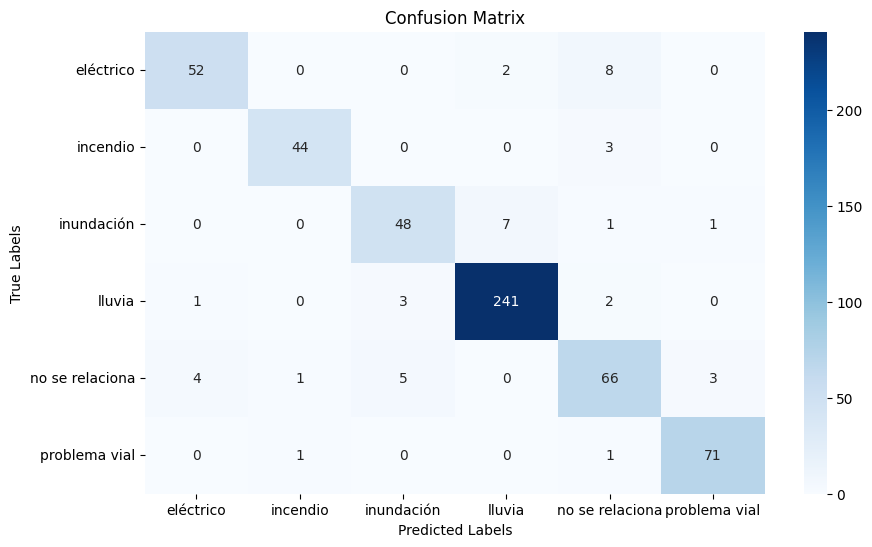

In [21]:
# Crear la matriz de confusión
cm = confusion_matrix(test_labels.numpy(), preds)

# Graficar la matriz de confusión
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


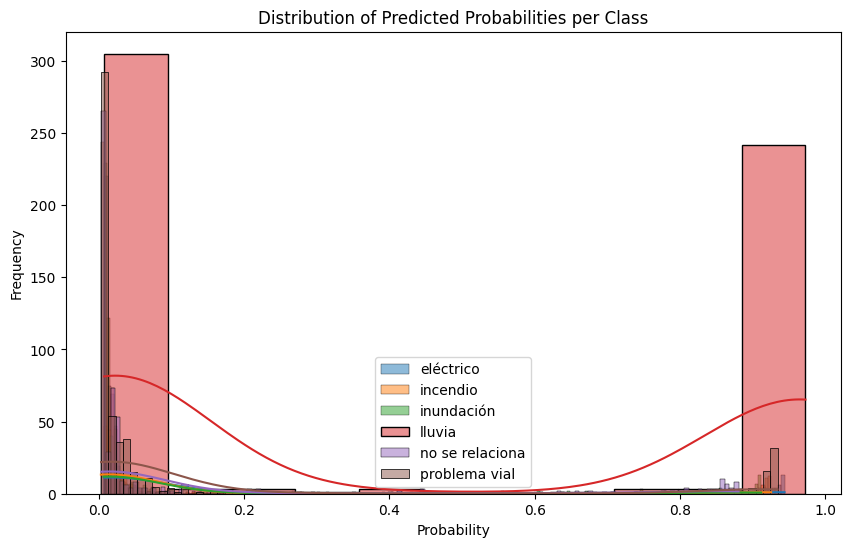

In [22]:
# Convertir probabilidades predichas a NumPy
pred_probs_np = pred_probs.detach().numpy()

# Graficar la distribución de probabilidades para cada clase
plt.figure(figsize=(10,6))
for i, class_label in enumerate(label_encoder.classes_):
    sns.histplot(pred_probs_np[:, i], label=class_label, kde=True)

plt.title('Distribution of Predicted Probabilities per Class')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()


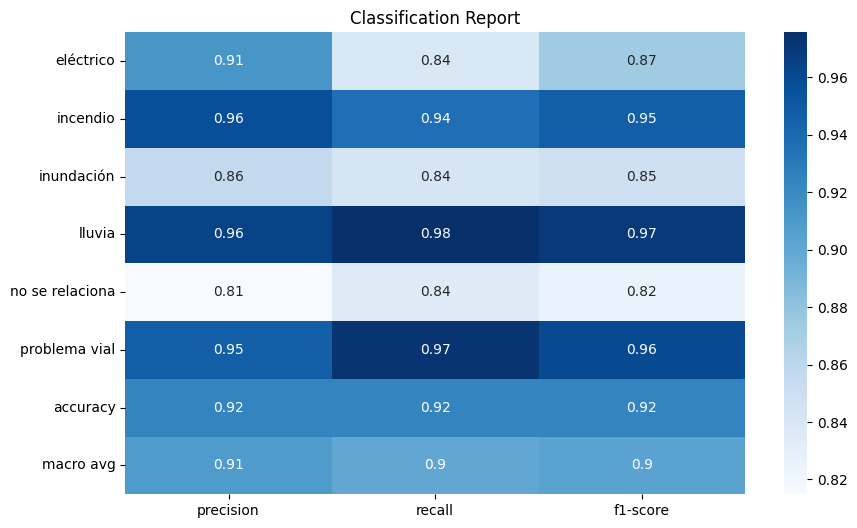

In [23]:
# Obtener el reporte de clasificación
report = classification_report(test_labels.numpy(), preds, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Graficar la tabla
plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues")
plt.title('Classification Report')
plt.show()


In [24]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax

# Cargar el modelo y el tokenizer pre-entrenado
model = BertForSequenceClassification.from_pretrained('./my_model7')
tokenizer = BertTokenizer.from_pretrained('./my_model7')
# Definir un texto de ejemplo
texto_ejemplo = "Se dañó un transformador eléctrico y se incendió"

# Tokenizar el texto
inputs = tokenizer(texto_ejemplo, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Asegurarse de que el modelo está en modo de evaluación
model.eval()

# Hacer la predicción (no se necesita calcular los gradientes)
with torch.no_grad():
    outputs = model(**inputs)

# Obtener las logits y calcular las probabilidades con softmax
logits = outputs.logits
probabilidades = softmax(logits.numpy(), axis=1)[0]

# Cargar el LabelEncoder para obtener las categorías
df = pd.read_csv("df_tweets_procesados.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])

# Obtener los nombres de las categorías
categorias = label_encoder.classes_

# Crear un nuevo DataFrame con las categorías y las probabilidades
df_resultado = pd.DataFrame([probabilidades], columns=categorias)

# Agregar el texto de ejemplo para referencia
df_resultado['Texto'] = texto_ejemplo

# Mostrar el DataFrame con las categorías y sus porcentajes de presencia
print(df_resultado)

   eléctrico  incendio  inundación    lluvia  no se relaciona  problema vial  \
0   0.453097  0.394085    0.030106  0.014157         0.049073       0.059482   

                                              Texto  
0  Se dañó un transformador eléctrico y se incendió  
